In [1]:
# Web Scraping
from tqdm import tqdm
from bs4 import BeautifulSoup
import requests

# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import random

# Warnings Configuration
import warnings
warnings.filterwarnings("ignore")

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import metrics
from sklearn.impute import SimpleImputer

# Configuration Settings
plt.style.use('ggplot')  # for coloring the graphs

# Seed Initialization
np.random.seed(42)
random.seed(42)

# Ignore Warnings
warnings.filterwarnings('ignore')

# Configuring sklearn
sklearn.set_config(transform_output='pandas')

# 4.1 Collecte de données (6pts) 

In [2]:
#Cette fonction recupère les adresses de la maison : adresse, ville et region
def get_addresses(roomAddr):
  addressesValues = {}
  addressesValues['address'] = roomAddr.h1.text.strip() #1
  addressesValues['city'] = roomAddr.find_all("span")[0].text.strip() #2
  addressesValues['region'] = roomAddr.find_all("span")[1].text.strip() #3

  return addressesValues

In [3]:
#Cette fonction recupère les détails de la maison à savoir : nbRooms, nbBathrooms, nbWaterRooms, nbStages, livingArea, livingAreaSize
def get_room_characteristics(characteristics):
  charactValues={'nbRooms':np.nan, 'nbBathrooms':np.nan, 'nbWaterRooms':np.nan,
                   'nbStages':np.nan, 'livingArea':np.nan, 'livingAreaSize':np.nan}

  for element in characteristics:
    if element.find("span", class_="listing-main-characteristics__title").text.strip() == "chambres":
      charactValues['nbRooms'] = element.find("span", class_="listing-main-characteristics__number").text.strip()
    elif element.find("span", class_="listing-main-characteristics__title").text.strip() == "salles de bain":
      charactValues['nbBathrooms'] = element.find("span", class_="listing-main-characteristics__number").text.strip()
    elif element.find("span", class_="listing-main-characteristics__title").text.strip() == "salle d’eau":
      charactValues['nbWaterRooms'] = element.find("span", class_="listing-main-characteristics__number").text.strip()
    elif element.find("span", class_="listing-main-characteristics__title").text.strip() == "étages":
      charactValues['nbStages'] = element.find("span", class_="listing-main-characteristics__number").text.strip()
    elif element.find("span", class_="listing-main-characteristics__title").text.strip() == "Aire habitable (s-sol exclu)":
      livingArea = element.find("span", class_="listing-main-characteristics__number").text.strip()
      charactValues['livingArea'] = livingArea[0:livingArea.find('pi')]
    elif element.find("span", class_="listing-main-characteristics__title").text.strip() == "Taille du terrain":
      livingAreaSize = element.find("span", class_="listing-main-characteristics__number").text.strip()
      charactValues['livingAreaSize'] = livingAreaSize[0:livingAreaSize.find('pi')]
  return charactValues

In [4]:
#Cette fonction recupère les montants annuels comme : propertyTaxe, schoolTaxe, electricity, insurance
def get_yearly_costs(table):
  tableValues = {'propertyTaxe':np.nan, 'schoolTaxe':np.nan, 'electricity':np.nan, 'insurance':np.nan}

  for row in table:
    if row.find("div", class_="mortgage-data__table__row__item--name").text.strip() == "Taxes municipales":
      tableValues['propertyTaxe'] = row.find("div", class_="mortgage-data__table__row__item--yearly-costs").text.strip() #Le montant annuel des taxes municipales;
    elif row.find("div", class_="mortgage-data__table__row__item--name").text.strip() == "Taxes scolaires":
      tableValues['schoolTaxe'] = row.find("div", class_="mortgage-data__table__row__item--yearly-costs").text.strip() #Le montant annuel des taxes scolaires;
    elif row.find("div", class_="mortgage-data__table__row__item--name").text.strip() == "Électricité":
      tableValues['electricity'] = row.find("div", class_="mortgage-data__table__row__item--yearly-costs").text.strip() #Le montant annuel de l’électricité;
    elif row.find("div", class_="mortgage-data__table__row__item--name").text.strip() == "Assurances":
      tableValues['insurance'] = row.find("div", class_="mortgage-data__table__row__item--yearly-costs").text.strip() #Le montant annuel des assurances.
  return tableValues

In [5]:
def scrape_and_save_data(pages=711):
    colNames = ["Adresse", "Prix", "Ville", "Région", "Chambres", "Salles de bain", "Salles d'eau", "Etages",
                "Aire habitable", "Taille terrain", "Taxes municipales", "Taxes scolaires", "Electricité", "Assurances"]
    dataset = pd.DataFrame(columns=colNames)

    for page in tqdm(range(pages)):
        try:
            URL = "https://duproprio.com/fr/rechercher/liste?search=true&parent=1&pageNumber=" + str(page)
            webpage = requests.get(URL)
            soup = BeautifulSoup(webpage.content, "html.parser")
            links = soup.find_all("a", {"class": "search-results-listings-list__item-image-link"})

            for link in links:
                roomDetailsPage = requests.get(link['href'])
                soup2 = BeautifulSoup(roomDetailsPage.content, "html.parser")

                roomAddr = soup2.find("div", class_="listing-location__address")
                characteristics = soup2.find_all("div", class_="listing-main-characteristics__item")
                table = soup2.find_all("div", class_="mortgage-data__table__row")

                addressesValues = get_addresses(roomAddr)
                charactValues = get_room_characteristics(characteristics)
                tableValues = get_yearly_costs(table)

                room = {**addressesValues, **charactValues, **tableValues}
                dataset.loc[len(dataset)] = room
        except Exception as e:
            print(f"An error occurred on page {page}: {e}")
            continue

    dataset.to_csv('house_data.csv', index=False)

# Example usage:
# scrape_and_save_data()

# 4.2 Nettoyage et exploration des données (4pts)

In [6]:
house = pd.read_csv("house_data.csv").drop('Unnamed: 0',axis=1) #supprimer les numéros de lignes

In [7]:
house.head()

,prix,Taxes_municipales,Taxes_scolaires,Electricite,Assurances,ville,region,adresse,chambres,salle_de_bain,salle_d_eau,etage,Aire_habitable,Taille_du_terrain
0,549000$,NaN,NaN,NaN,NaN,Lac-Beauport,Québec Rive-Nord,"4, montée du Bois-Franc",4.0,2.0,NaN,1.0,"1,050 pi² (97.55 m²)","14,650 pi² (1,361.03 m²)"
1,329000$,NaN,NaN,NaN,NaN,Jonquière (Arvida),Saguenay-Lac-Saint-Jean,"2263, rue Vallerand",5.0,2.0,NaN,1.0,988 pi² (91.79 m²),5 428 pi² (504.28 m²)
2,495000$,"2344,00$","232,00$","1500,00$",NaN,Anjou,Montréal / l'Île,"103-6850, boulevard des Roseraies",3.0,2.0,NaN,1.0,"1,250 pi² (116.13 m²)",662.84 pi² (61.58 m²)
3,749000$,"4032,90$","427,49$",NaN,NaN,Longueuil (St-Hubert),Montérégie (Rive-Sud Montréal),"3450, rue Ovila-Hamel",7.0,2.0,1.0,2.0,2 023 pi² (187.94 m²),4 843.76 pi² (450 m²)
4,340000$,"1259,36$","130,82$","1000,00$","994,00$",St-Alban,Portneuf,"139, Chemins des Rapides",3.0,1.0,NaN,1.0,"1,411.15 pi² (131.1 m²)","18,023.09 pi² (1,674.4 m²)"


#### 1. Combien ya-t-il de valeurs manquantes dans chaque colonne de votre jeu de donnees?


In [8]:
house.isna().sum()

prix                    0
Taxes_municipales    1788
Taxes_scolaires      2100
Electricite          3485
Assurances           4528
ville                   0
region                  0
adresse                 0
chambres             1161
salle_de_bain        1228
salle_d_eau          4350
etage                1841
Aire_habitable       2227
Taille_du_terrain    1232
dtype: int64

***Réponse 1 :*** Dans ce jeu de données nous pouvons remarquer que la plupart des colonnes contiennent de valeurs manquantes qui sont: </br>
* Taxes_municipales  :  1788
* Taxes_scolaires    :  2100
* Electricite        :  3485
* Assurances         :  4528
* chambres           :  1161
* salle_de_bain      :  1228
* salle_d_eau        :  4350
* etage              :  1841
* Aire_habitable     :  2227
* Taille_du_terrain  :  1232

In [9]:
# Voir le pourcentage de valeurs manquantes par colonne.
(house.isna().sum()/ len(house)) 

prix                 0.000000
Taxes_municipales    0.262170
Taxes_scolaires      0.307918
Electricite          0.510997
Assurances           0.663930
ville                0.000000
region               0.000000
adresse              0.000000
chambres             0.170235
salle_de_bain        0.180059
salle_d_eau          0.637830
etage                0.269941
Aire_habitable       0.326540
Taille_du_terrain    0.180645
dtype: float64

#### 2. Selon vous, quel est la cause de ces valeurs manquantes ? Est-ce que parmi les colonnes qui ont des valeurs manquantes, on pourrait utiliser l’une des techniques de remplacement de valeurs manquantes vues en cours ? Si oui dites pour les colonnes concernées, lesquelles des techniques fonctionneraient bien

**Réponse 2:**
* Plusieurs facteurs peuvent être la cause de valeurs manquantes comme par example:
    1. Erreur de saisie lors de la collecte de données.
    2. L'information n'est pas disponible au moment de la collecte ou de la saisie
    3. Dans certains cas, les données peuvent ne pas être applicables.

* Pour corriger ce problème, nous pouvons utiliser certaines techniques de remplacement vues en cours. Etant donnée que les variables contenant de valeurs de manquantes sont de types numériques, nous pouvons choisir l'une des techniques suivantes: 
    - Imputation par la moyenne, la médiane, par régression ou modèle prédictif (pour les variables discretes, on va arrondir le resultat à l'entier proche).
    - Suppression des lignes : Si le nombre de lignes avec des valeurs manquantes est relativement faible par rapport à la taille totale du jeu de données.

#### 3. Combien ya t-il de régions différentes ? et de villes différentes ?

In [10]:
house['region'].unique() # Cette ligne va afficher l'ensemble des regions de facons unique.

# Le number de regions differentes
house['region'].nunique()

21

**Réponse 3a :** Dans notre dataset il y'a 21 regions differentes.

In [11]:
house['ville'].nunique()

918

**Réponse 3b:** Dans notre dataset il y'a 918 ville differentes.

#### 4. Quel est le type (infere par pandas) de donnees de chaque colonne ?


In [12]:
house.dtypes

prix                  object
Taxes_municipales     object
Taxes_scolaires       object
Electricite           object
Assurances            object
ville                 object
region                object
adresse               object
chambres             float64
salle_de_bain        float64
salle_d_eau          float64
etage                float64
Aire_habitable        object
Taille_du_terrain     object
dtype: object

In [13]:
house.dtypes.value_counts()

object     10
float64     4
Name: count, dtype: int64

Dans notre jeux de données on a 10 colonnees de type Object qui sont: **prix,Taxes_municipales,Taxes_scolaire, Electricite, Assurances, ville, region, adresse ,Aire_habitable ,Taille_du_terrain** </br>

Egalement, il y'a 4 colonnes de types float qui sont: **chambres, salle_de_bain, salle_d_eau, etage.**

#### 5. Nettoyer vos donnees : correction d’erreurs, traitement de valeurs manquantes s’il ya lieu, correction du type des donnees

La premiere de chose a faire ici est de remplacer le **$** par un vide, ensuite remplacer les **,** par **.**, et enfin convertir les donnees numériques en **float**

In [14]:
def clean_currency_column(column):
    column = column.astype(str)
    column = column.str.replace('$', '')
    column = column.str.replace(',', '.')
    column = column.apply(lambda x: np.NaN if x == 'Prixsurdemande' else x)
    column = column.astype(float)
    return column

# Appliquer la fonction aux colonnes concernées
columns_to_clean = ['prix', 'Taxes_municipales', 'Taxes_scolaires', 'Electricite', 'Assurances']

for col in columns_to_clean:
    house[col] = clean_currency_column(house[col])

In [15]:
house.head()

,prix,Taxes_municipales,Taxes_scolaires,Electricite,Assurances,ville,region,adresse,chambres,salle_de_bain,salle_d_eau,etage,Aire_habitable,Taille_du_terrain
0,549000.0,NaN,NaN,NaN,NaN,Lac-Beauport,Québec Rive-Nord,"4, montée du Bois-Franc",4.0,2.0,NaN,1.0,"1,050 pi² (97.55 m²)","14,650 pi² (1,361.03 m²)"
1,329000.0,NaN,NaN,NaN,NaN,Jonquière (Arvida),Saguenay-Lac-Saint-Jean,"2263, rue Vallerand",5.0,2.0,NaN,1.0,988 pi² (91.79 m²),5 428 pi² (504.28 m²)
2,495000.0,2344.00,232.00,1500.0,NaN,Anjou,Montréal / l'Île,"103-6850, boulevard des Roseraies",3.0,2.0,NaN,1.0,"1,250 pi² (116.13 m²)",662.84 pi² (61.58 m²)
3,749000.0,4032.90,427.49,NaN,NaN,Longueuil (St-Hubert),Montérégie (Rive-Sud Montréal),"3450, rue Ovila-Hamel",7.0,2.0,1.0,2.0,2 023 pi² (187.94 m²),4 843.76 pi² (450 m²)
4,340000.0,1259.36,130.82,1000.0,994.0,St-Alban,Portneuf,"139, Chemins des Rapides",3.0,1.0,NaN,1.0,"1,411.15 pi² (131.1 m²)","18,023.09 pi² (1,674.4 m²)"


In [16]:
house['Assurances'].isna().sum()

4528

On remarque sur nos jeux de donnee que y'a des lignes qui contienent des valueurs **nan** qui est different de **NaN** considerer comme valeur manquante en pandas donc on doit remplacer ces valeur par **np.nan** valeurs manquantes pour mieux comprendres nos jeux de donnee.

In [17]:
# house['salle_d_eau'] = house['salle_d_eau'].astype('str')
# house['salle_d_eau'] = [x.replace('nan', '') for x in house['salle_d_eau']]

In [18]:
house['Taxes_municipales'] 

0           NaN
1           NaN
2       2344.00
3       4032.90
4       1259.36
         ...   
6815    3350.00
6816    2384.62
6817        NaN
6818    1600.00
6819    3830.00
Name: Taxes_municipales, Length: 6820, dtype: float64

In [19]:
# house['Electricite'] = house['Electricite'].astype('str')
# house['Electricite'] = [x.replace('nan',' ') for x in house['Electricite']]

In [20]:
# house.isna().sum()
(house.isna().sum()/ len(house))*100

prix                  0.703812
Taxes_municipales    26.217009
Taxes_scolaires      30.791789
Electricite          51.099707
Assurances           66.392962
ville                 0.000000
region                0.000000
adresse               0.000000
chambres             17.023460
salle_de_bain        18.005865
salle_d_eau          63.782991
etage                26.994135
Aire_habitable       32.653959
Taille_du_terrain    18.064516
dtype: float64

In [21]:
columns_to_fillna = ['prix', 'Taxes_municipales', 'Taxes_scolaires', 'Electricite', 
                     'Assurances', 'chambres', 'salle_de_bain', 'salle_d_eau', 'etage']

for col in columns_to_fillna:
    house[col] = house[col].fillna(house[col].mean())

In [22]:
house.describe()

,prix,Taxes_municipales,Taxes_scolaires,Electricite,Assurances,chambres,salle_de_bain,salle_d_eau,etage
count,6.820000e+03,6820.000000,6820.000000,6820.000000,6820.000000,6820.000000,6820.000000,6820.000000,6820.000000
mean,5.380000e+05,3270.880702,373.692328,1968.549376,1566.970707,3.403251,1.688662,1.131174,1.639486
std,1.292465e+06,5565.098969,1096.936937,1313.712444,4448.231962,1.847690,0.878860,0.296506,2.772497
min,2.500000e-01,1.000000,0.010000,0.010000,0.010000,1.000000,1.000000,1.000000,1.000000
25%,2.950000e+05,2238.000000,227.127500,1750.000000,1566.970707,2.000000,1.000000,1.000000,1.000000
50%,4.399500e+05,3270.880702,373.692328,1968.549376,1566.970707,3.000000,1.688662,1.131174,1.639486
75%,6.490000e+05,3270.880702,373.692328,1968.549376,1566.970707,4.000000,2.000000,1.131174,2.000000
max,1.000000e+08,326000.000000,69250.000000,42000.000000,358500.000000,43.000000,15.000000,10.000000,218.000000


In [23]:
house['Aire_habitable'] = house['Aire_habitable'].str.split().str[0].str.replace(',', '')
house['Aire_habitable'] = pd.to_numeric(house['Aire_habitable'], errors='coerce')

house['Taille_du_terrain'] = house['Taille_du_terrain'].str.split().str[0].str.replace(',', '')
house['Taille_du_terrain'] = pd.to_numeric(house['Taille_du_terrain'], errors='coerce')

house['Aire_habitable'] = house['Aire_habitable'].fillna(house['Aire_habitable'].mean())
house['Taille_du_terrain'] = house['Taille_du_terrain'].fillna(house['Taille_du_terrain'].mean())

In [24]:
columns_to_fillna = ['ville', 'region', 'adresse']

for col in columns_to_fillna:
    house[col] = house[col].fillna(house[col].mode()[0])

In [25]:
house

,prix,Taxes_municipales,Taxes_scolaires,Electricite,Assurances,ville,region,adresse,chambres,salle_de_bain,salle_d_eau,etage,Aire_habitable,Taille_du_terrain
0,549000.0,3270.880702,373.692328,1968.549376,1566.970707,Lac-Beauport,Québec Rive-Nord,"4, montée du Bois-Franc",4.000000,2.000000,1.131174,1.000000,1050.000000,1.465000e+04
1,329000.0,3270.880702,373.692328,1968.549376,1566.970707,Jonquière (Arvida),Saguenay-Lac-Saint-Jean,"2263, rue Vallerand",5.000000,2.000000,1.131174,1.000000,988.000000,5.000000e+00
2,495000.0,2344.000000,232.000000,1500.000000,1566.970707,Anjou,Montréal / l'Île,"103-6850, boulevard des Roseraies",3.000000,2.000000,1.131174,1.000000,1250.000000,6.628400e+02
3,749000.0,4032.900000,427.490000,1968.549376,1566.970707,Longueuil (St-Hubert),Montérégie (Rive-Sud Montréal),"3450, rue Ovila-Hamel",7.000000,2.000000,1.000000,2.000000,2.000000,4.000000e+00
4,340000.0,1259.360000,130.820000,1000.000000,994.000000,St-Alban,Portneuf,"139, Chemins des Rapides",3.000000,1.000000,1.131174,1.000000,1411.150000,1.802309e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,675000.0,3350.000000,750.000000,1968.549376,700.000000,Chateauguay,Montérégie (Rive-Sud Montréal),"139, rue des Sittelles",3.000000,2.000000,1.000000,2.000000,1640.000000,4.276000e+03
6816,345000.0,2384.620000,493.700000,1968.549376,1566.970707,Beauport,Québec Rive-Nord,"114, RUE CHOISY",3.000000,2.000000,1.000000,1.000000,1012.000000,3.184708e+07
6817,249900.0,3270.880702,373.692328,1968.549376,1566.970707,Rivière-Madeleine,Gaspésie-Îles-de-la-Madeleine,"115, rue Principale",8.000000,2.000000,1.131174,1.639486,1280.655809,3.184708e+07
6818,159900.0,1600.000000,373.692328,2500.000000,1566.970707,Rivière-Madeleine,Gaspésie-Îles-de-la-Madeleine,"85, rue Principale",3.403251,1.688662,1.131174,1.639486,1280.655809,3.184708e+07


In [26]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   prix               6820 non-null   float64
 1   Taxes_municipales  6820 non-null   float64
 2   Taxes_scolaires    6820 non-null   float64
 3   Electricite        6820 non-null   float64
 4   Assurances         6820 non-null   float64
 5   ville              6820 non-null   object 
 6   region             6820 non-null   object 
 7   adresse            6820 non-null   object 
 8   chambres           6820 non-null   float64
 9   salle_de_bain      6820 non-null   float64
 10  salle_d_eau        6820 non-null   float64
 11  etage              6820 non-null   float64
 12  Aire_habitable     6820 non-null   float64
 13  Taille_du_terrain  6820 non-null   float64
dtypes: float64(11), object(3)
memory usage: 746.1+ KB


In [27]:
# Extracting the numeric value
#house['Taille_du_terrain'] = house['Taille_du_terrain'].str.extract(r'\(([\d,]+\.\d+)\s*m²\)')
#house['Taille_du_terrain'] = house['Taille_du_terrain'].str.replace(',', '').astype(float)

In [28]:
house.isna().sum()

prix                 0
Taxes_municipales    0
Taxes_scolaires      0
Electricite          0
Assurances           0
ville                0
region               0
adresse              0
chambres             0
salle_de_bain        0
salle_d_eau          0
etage                0
Aire_habitable       0
Taille_du_terrain    0
dtype: int64

#### 6. Quel est le prix moyen des maisons (au moins 1 chambre et 1 salle de bain) sur l’île de Montréal ? A Laval ? Dans les laurentides 

In [29]:
house_ = house[house['region'].isin(["Montréal / l'Île", 'Laval', 'Laurentides'])]

prix_moyen = house_[(house_['chambres'] >= 1) & (house_['salle_de_bain'] >= 1)]
prix_moyen_par_region = prix_moyen.groupby('region')['prix'].mean()
prix_moyen_par_region

region
Laurentides         584672.999120
Laval               691714.524064
Montréal / l'Île    855359.847509
Name: prix, dtype: float64

7. Dans quelle ville de Montréal/l’Ile les maisons (au moins 1 chambre et 1 salle de bain) coûtent le moins chers?

In [30]:
prix_moyen = house[(house['region'] == "Montréal / l'Île") & (house['chambres'] >= 1) & (house['salle_de_bain'] >= 1)]
prix_moyen_par_region = prix_moyen.groupby('ville')['prix'].mean()
nom_ville_prix_moins_cher= prix_moyen_par_region.idxmin()
prix_ville_moins_cher = prix_moyen_par_region.loc[prix_moyen_par_region.idxmin()]

print("La ville ou les maisons coutent le moins cher est: {0}, avec un prix moyen de {1}.".format(
    nom_ville_prix_moins_cher, prix_ville_moins_cher))

La ville ou les maisons coutent le moins cher est: Ste-Anne-De-Bellevue, avec un prix moyen de 565000.0.


#### 8. Pour chaque région, afficher le prix de l’item (annonce) le plus élevé et la ville où l’item se situe. Ici on ne fait pas de différence si c’est un condo/appartement, maison, terrain vide, etc. A quel région/ville revient la palme d’or de l’item le plus cher ? Donner toutes les caractéristiques (valeurs de toutes les colonnes) de cet item.

In [31]:
# Trouver l'annonce la plus chère dans chaque région
max_priced_per_region = house.groupby('region').apply(lambda x: x.loc[x['prix'].idxmax()])

# Extraction du prix maximal et de la ville correspondante pour chaque région
max_price_city_per_region = max_priced_per_region[['ville', 'prix']]

In [32]:
max_price_city_per_region

,ville,prix
region,,
Abitibi-Témiscamingue,Ville-Marie,792800.00
Bas-Saint-Laurent,St-Ulric,4000000.00
Centre-du-Québec,St-Christophe-D'Arthabaska,5000000.00
Charlevoix,Les Éboulements,2095000.00
Chaudière-Appalaches,Ste-Croix,2999999.00
Côte-Nord,Sept-Iles,1200000.00
Estrie,Sherbrooke (Fleurimont),3650000.00
Gaspésie-Îles-de-la-Madeleine,Percé,2300000.00
Lanaudière,Terrebonne (Terrebonne),2775000.00


# 4.3 Visualisation et analyse des données (6pts) 

#### 1. Présenter visuellement (a l’aide d’un graphique) la matrice de corrélation entre les colonnes numériques. Y a-t-il des corrélations de plus de 0.7 ? quelles sont elles ?

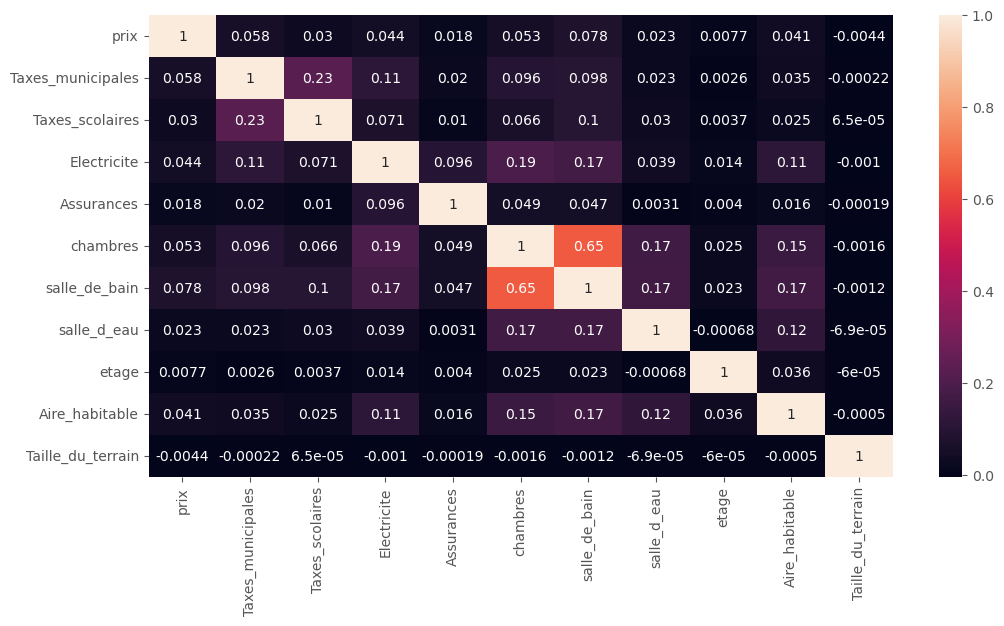

In [33]:
plt.figure(figsize=(12,6))
sns.heatmap(house.select_dtypes(exclude='O').corr(), annot=True,)
plt.show()


**Note :** D'après le graphique ci-dessus, la plus grand coefficient de corrélation est de 0.65.

#### 2. Presenter visuellement la proportion numerique de chaque region en matiere de nombre d’annonces, par rapport a l’ensemble des annonces. Quelle region occupe la plus petite proportion ?**

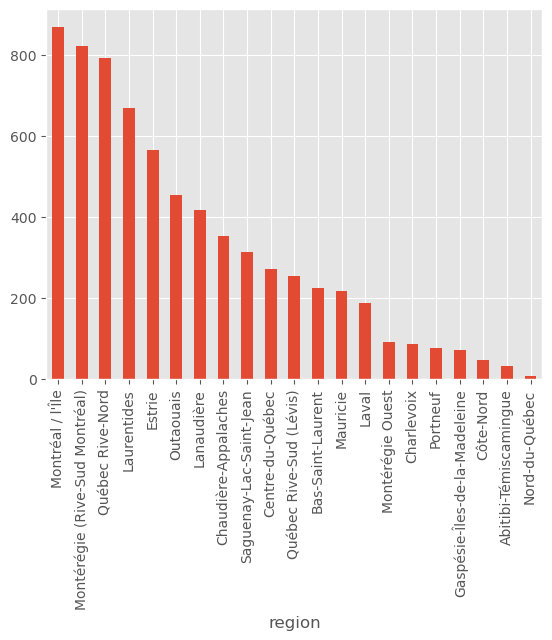

In [34]:
#plt.figure(figsize=(12,3))
house['region'].value_counts().plot(kind='bar')
plt.show()


#### 3. Une deuxième façon de le representer.

<Axes: xlabel='count', ylabel='region'>

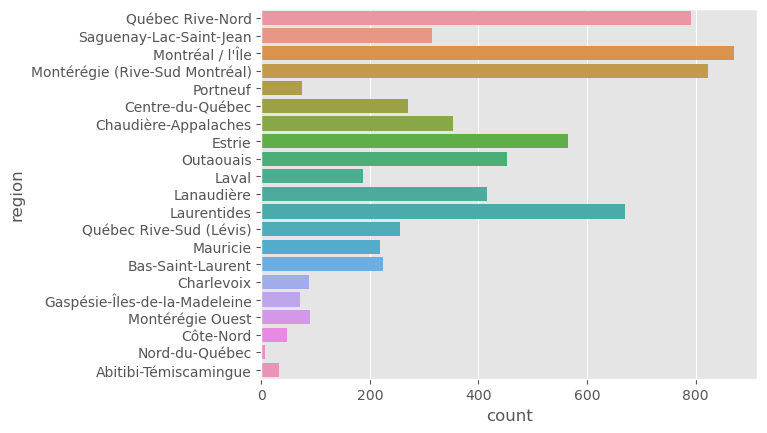

In [35]:
sns.countplot(y=house['region'],)

#### 3. A l’aide d’un graphique différent de celui de la question précédente, comparer le nombre d’annonces de vente pour chaque région. Quelle région possède le plus d’annonces de vente ?

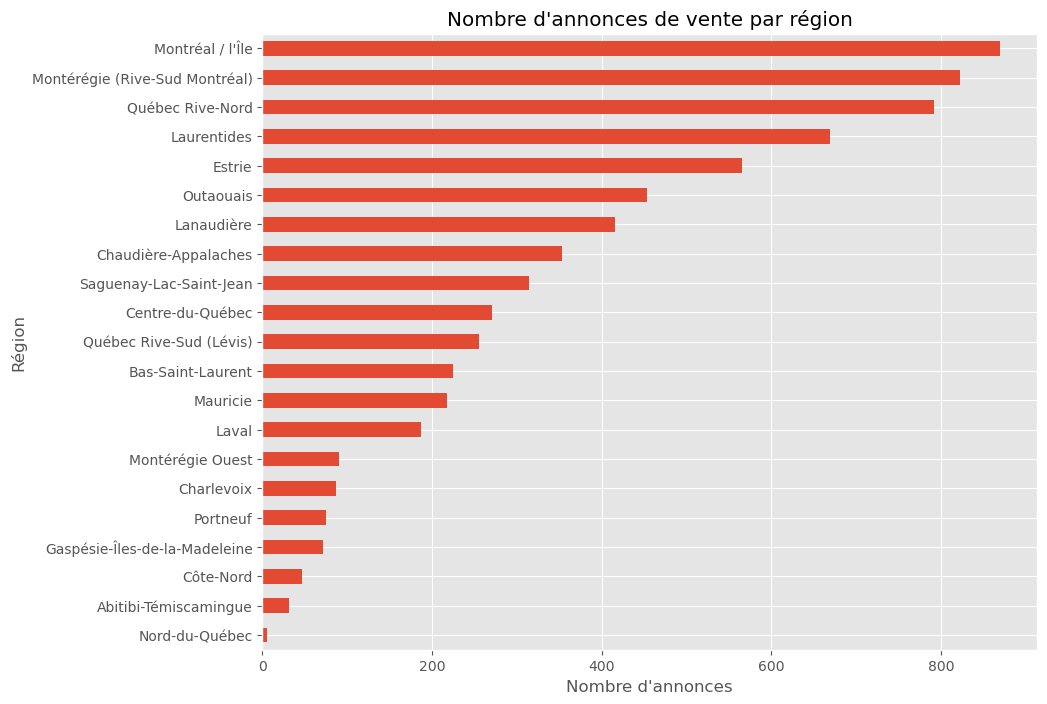

In [36]:
# Création d'un diagramme à barres horizontales pour comparer le nombre d'annonces par région
plt.figure(figsize=(10, 8))
house.region.value_counts().sort_values().plot(kind='barh')
plt.title("Nombre d'annonces de vente par région")
plt.xlabel("Nombre d'annonces")
plt.ylabel("Région")
plt.show()

# La région avec le plus grand nombre d'annonces a déjà été identifiée précédemment, mais la réaffichons pour référence


#### 4. A l’aide d’un graphique, comparer le prix moyen des annonces pour chaque région. Quelle région possède le prix moyen le plus élevé ?


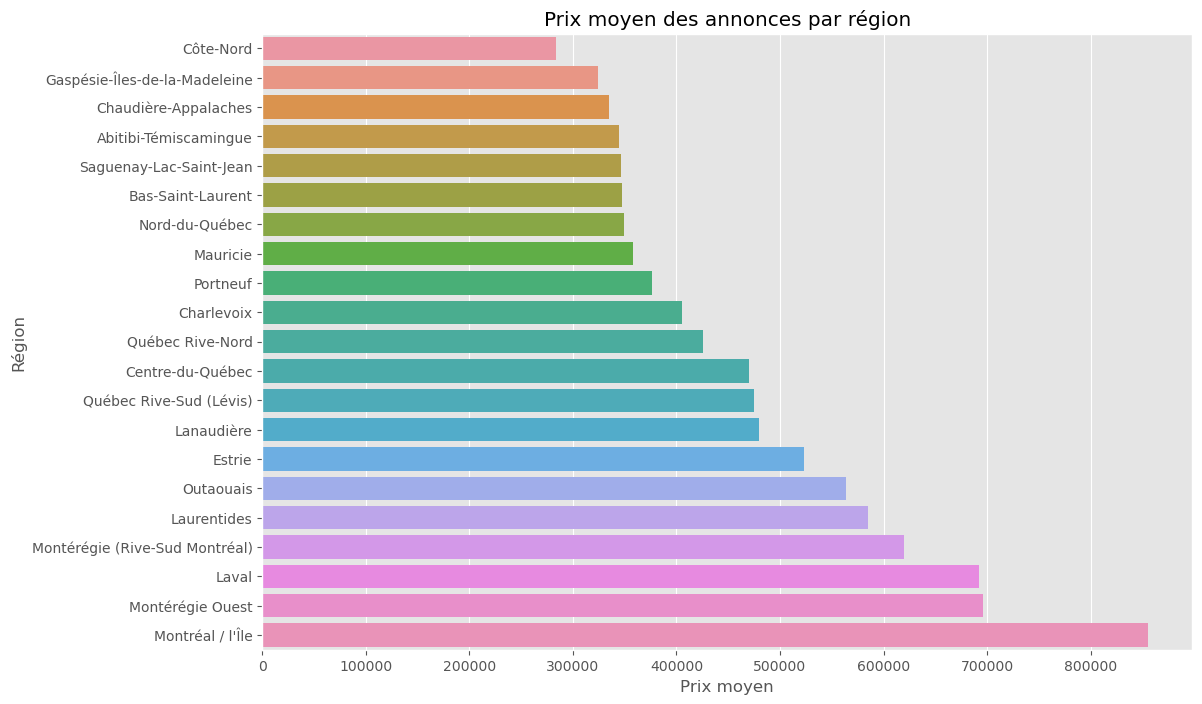

In [37]:
# Calculer le prix moyen par région
mean_price_by_region = house.groupby('region')['prix'].mean()

# Trier les régions par prix moyen pour une meilleure visualisation
sorted_mean_price_by_region = mean_price_by_region.sort_values()

# Création d'un graphique en barres pour comparer le prix moyen par région
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_mean_price_by_region.values, y=sorted_mean_price_by_region.index)
plt.title("Prix moyen des annonces par région")
plt.xlabel("Prix moyen")
plt.ylabel("Région")
plt.show()

# Identifier la région avec le prix moyen le plus élevé
#highest_price_region = mean_price_by_region.idxmax()
#highest_price_region_mean = mean_price_by_region.max()

#highest_price_region, highest_price_region_mean


#### 5. Pour ce point, on se limite aux annonces ayant au moins 1 chambre et 1 salle de bain. A l’aide d’un graphique, comparer le prix moyen de ces annonces pour chaque région. Quelle région possède le prix moyen le plus élevé pour les annonces avec au moins 1 chambre et 1 salle de bain?

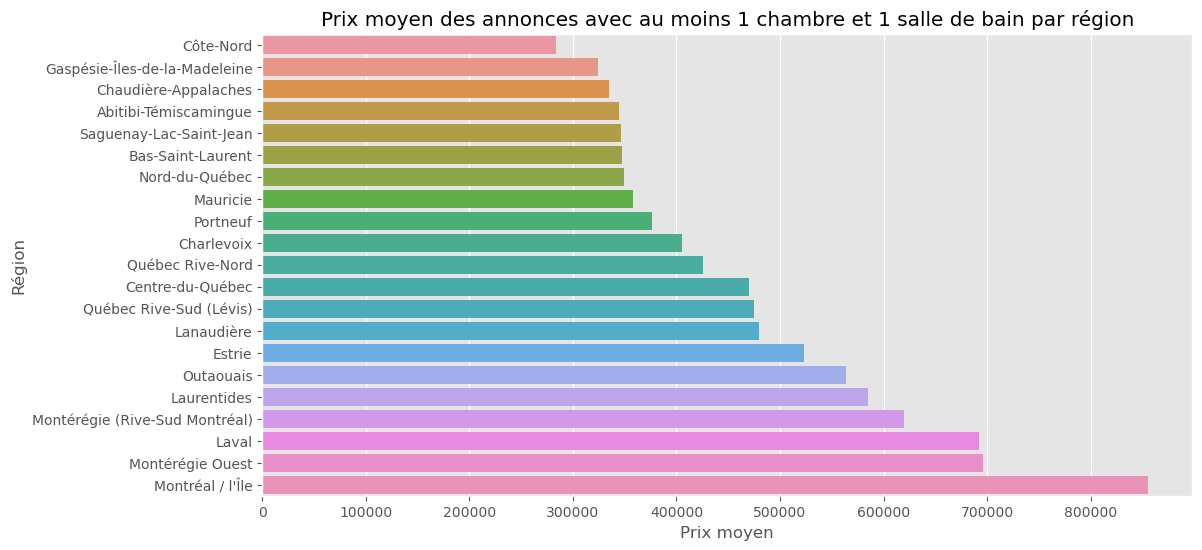

In [38]:
# Filtrer les données pour les annonces ayant au moins 1 chambre et 1 salle de bain
filtered_house = house[(house['chambres'] >= 1) & (house['salle_de_bain'] >= 1)]

# Calculer le prix moyen pour ces annonces dans chaque région
mean_price_filtered = house.groupby('region')['prix'].mean()

# Trier les régions par prix moyen pour une meilleure visualisation
sorted_mean_price_filtered = mean_price_filtered.sort_values()

# Création d'un graphique en barres pour comparer le prix moyen pour ces annonces par région
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_mean_price_filtered.values, y=sorted_mean_price_filtered.index)
plt.title("Prix moyen des annonces avec au moins 1 chambre et 1 salle de bain par région")
plt.xlabel("Prix moyen")
plt.ylabel("Région")
plt.show()

# Identifier la région avec le prix moyen le plus élevé pour ces annonces
#highest_price_filtered_region = mean_price_filtered.idxmax()
#highest_price_filtered_region_mean = mean_price_filtered.max()

#highest_price_filtered_region, highest_price_filtered_region_mean


#### 6. A l’aide d’un graphique, analyser la relation entre le prix des annonces et le nombre de chambres. Y a-t-il un lien quelconque ? Est-ce que la région y joue un rôle dans cette relation? Peut-on apercevoir des valeurs aberrantes ? Si oui identiez-les : donnez toutes les valeurs des colonnes de ces valeurs aberrantes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


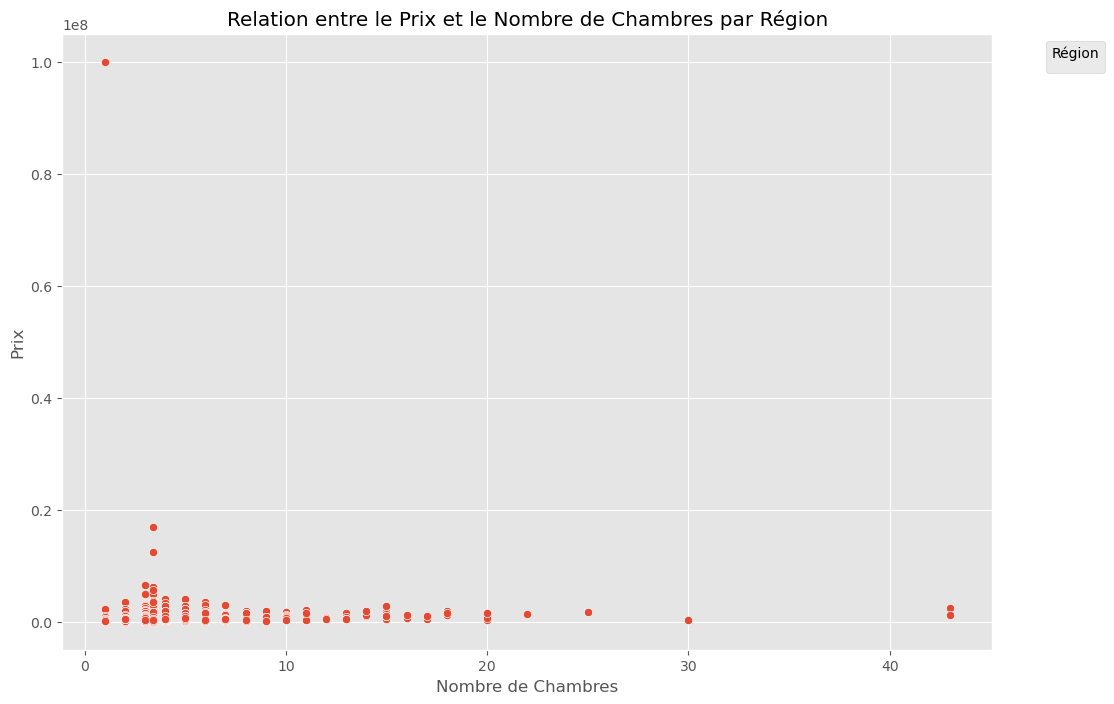

In [39]:

# Création d'un graphique de dispersion pour analyser la relation entre le prix et le nombre de chambres
plt.figure(figsize=(12, 8))
sns.scatterplot(x='chambres', y='prix',data=house, palette='viridis')
plt.title("Relation entre le Prix et le Nombre de Chambres par Région")
plt.xlabel("Nombre de Chambres")
plt.ylabel("Prix")
plt.legend(title='Région', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**A partir de cette representation graphique on peux voir qu'il n'existe vraiment pas un lien entre les deux variable. Donc la correlation est vraiment tres faible.**

* **Identification des valeurs abérantes**

In [40]:
#***************Identification des valeurs abérantes
Q1 = house[['prix','chambres']].quantile(0.25)
Q3 = house[['prix','chambres']].quantile(0.75)
IQR = (Q3 - Q1)

upper = Q3 + 1.5*IQR
lower = Q1-1.5*IQR

outliers  = house[((house[['prix','chambres']] < lower) |(house[['prix','chambres']] > upper)).any(axis=1)]
print(outliers[['prix','chambres']])

           prix  chambres
46    1250000.0  3.403251
68    1499999.0  4.000000
75    1575000.0  3.000000
77     845000.0  8.000000
103   1199000.0  4.000000
...         ...       ...
6686  1350000.0  4.000000
6705  1199000.0  4.000000
6771  1495000.0  6.000000
6804  1999000.0  4.000000
6817   249900.0  8.000000

[485 rows x 2 columns]


In [41]:
house.select_dtypes(exclude='O').corr()['prix']

prix                 1.000000
Taxes_municipales    0.058275
Taxes_scolaires      0.030431
Electricite          0.043927
Assurances           0.017769
chambres             0.052945
salle_de_bain        0.077661
salle_d_eau          0.022602
etage                0.007650
Aire_habitable       0.041252
Taille_du_terrain   -0.004430
Name: prix, dtype: float64

#### 7. A l’aide d’un graphique, analyser la relation entre la valeur des taxes municipales annuelles des annonces et la taille du terrain. Y a-t-il un lien quelconque ? Est-ce que la région y joue un rôle dans cette relation? Peut-on apercevoir des valeurs aberrantes ? Si oui identifiez-les : donnez toutes les valeurs des colonnes de ces valeurs aberrantes.

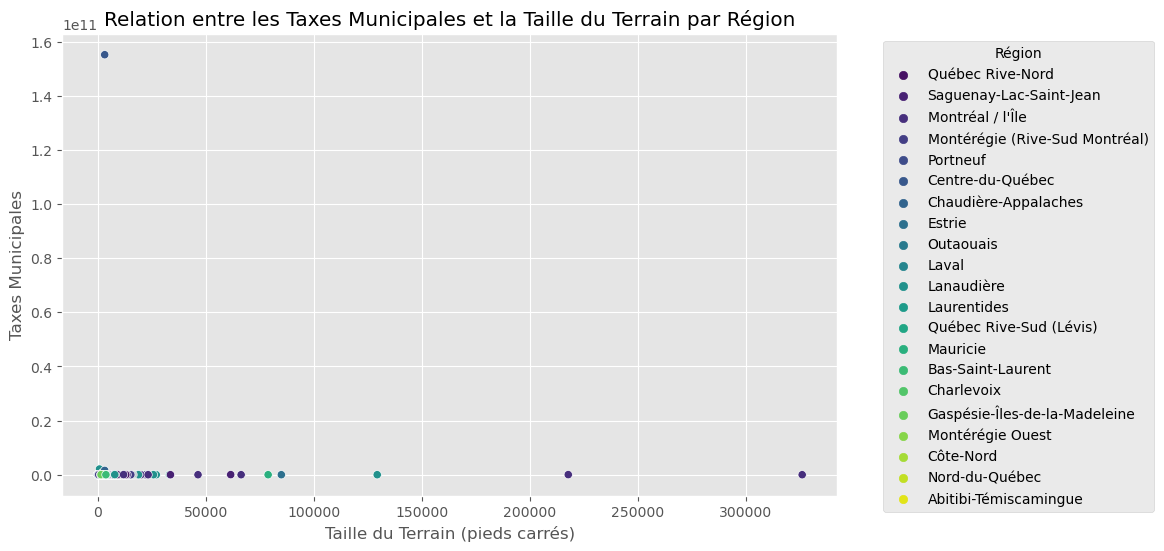

In [42]:
# Création d'un graphique de dispersion pour analyser la relation entre les taxes municipales et la taille du terrain
plt.figure(figsize=(10, 6))
sns.scatterplot( x='Taxes_municipales', y='Taille_du_terrain',hue='region', data=house, palette='viridis')
plt.title("Relation entre les Taxes Municipales et la Taille du Terrain par Région")
plt.xlabel("Taille du Terrain (pieds carrés)")
plt.ylabel("Taxes Municipales")
plt.legend(title='Région', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


* **Identification des valeurs abérantes**

In [43]:
#******************** Valeurs abérantes
Q1 = house[['Taxes_municipales','Taille_du_terrain']].quantile(0.25)
Q3 = house[['Taxes_municipales','Taille_du_terrain']].quantile(0.75)
IQR = (Q3 - Q1)

upper = Q3 + 1.5*IQR
lower = Q1-1.5*IQR

outliers  = house[((house[['Taxes_municipales','Taille_du_terrain']] < lower) |(house[['Taxes_municipales','Taille_du_terrain']] > upper)).any(axis=1)]
print(outliers[['Taxes_municipales','Taille_du_terrain']])

      Taxes_municipales  Taille_du_terrain
31               185.24       2.200000e+01
41              5845.00       6.000000e+00
62              5357.27       1.100000e+01
68              7479.52       3.184708e+07
70               500.97       8.700000e+01
...                 ...                ...
6789           61572.97       3.184708e+07
6795             378.82       3.184708e+07
6802             475.08       3.184708e+07
6803           12010.27       3.184708e+07
6804            7916.00       3.184708e+07

[798 rows x 2 columns]


#### 8. A l’aide d’un graphique, analyser la relation entre la valeur des taxes municipales annuelles des annonces et le prix. Il y a-t-il un lien quelconque ? Est-ce que la région y joue un rôle dans cette relation? Peut-on apercevoir des valeurs aberrantes ? Si oui identifiez-les : donnez toutes les valeurs des colonnes de ces valeurs aberrantes.

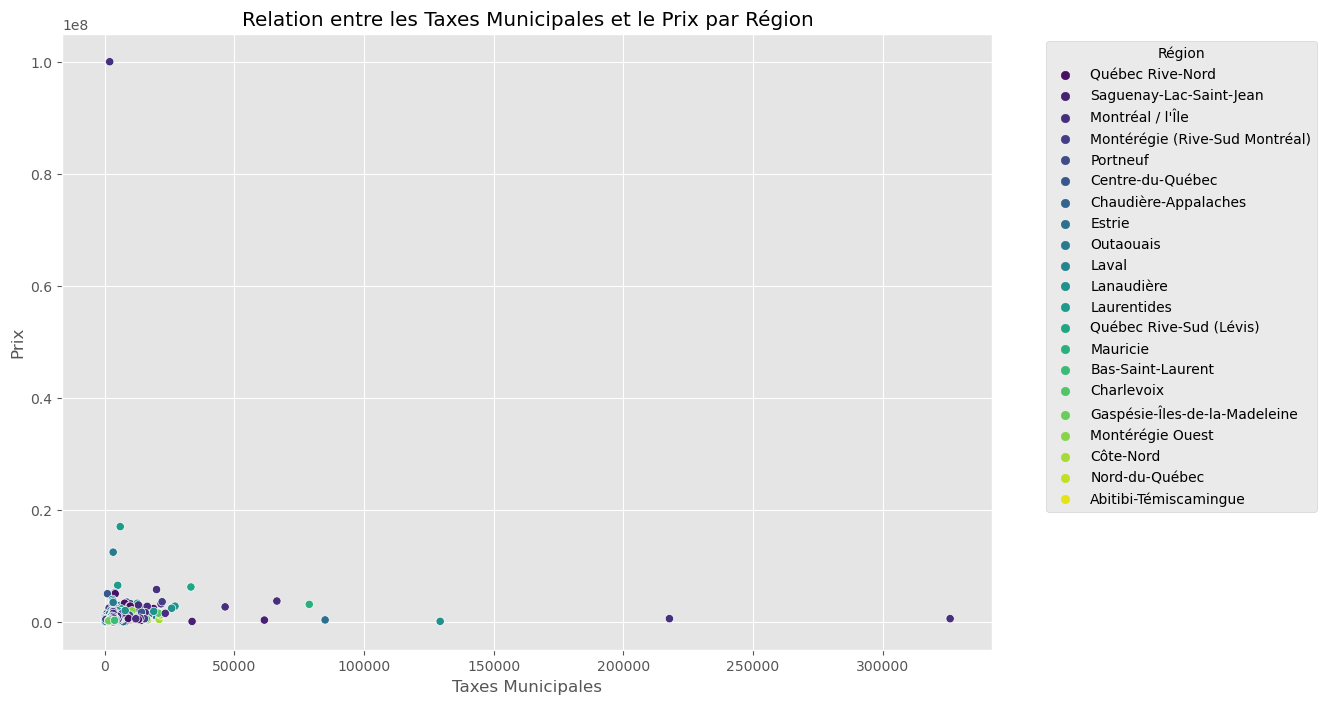

In [44]:
# Création d'un graphique de dispersion pour analyser la relation entre les taxes municipales et le prix
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Taxes_municipales', y='prix', hue='region', data=house, palette='viridis')
plt.title("Relation entre les Taxes Municipales et le Prix par Région")
plt.xlabel("Taxes Municipales")
plt.ylabel("Prix")
plt.legend(title='Région', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


* **Identification des valeurs abérantes**

In [45]:
#******************** Valeurs abérantes
Q1 = house[['Taxes_municipales','prix']].quantile(0.25)
Q3 = house[['Taxes_municipales','prix']].quantile(0.75)
IQR = (Q3 - Q1)

upper = Q3 + 1.5*IQR
lower = Q1-1.5*IQR

outliers  = house[((house[['Taxes_municipales','prix']] < lower) |(house[['Taxes_municipales','prix']] > upper)).any(axis=1)]
print(outliers[['Taxes_municipales','prix']])

      Taxes_municipales          prix
31           185.240000  7.474500e+04
41          5845.000000  9.500000e+05
46          3270.880702  1.250000e+06
62          5357.270000  6.750000e+05
68          7479.520000  1.499999e+06
...                 ...           ...
6789       61572.970000  2.905000e+05
6795         378.820000  6.990000e+04
6802         475.080000  4.200000e+05
6803       12010.270000  5.380000e+05
6804        7916.000000  1.999000e+06

[955 rows x 2 columns]


#### 9. On s’intéresse pour cette question aux annonces qui ont un prix affiché de moins de 1 million de $, pour toutes les régions. Dessiner dans un meme graphique un boxplot représentant la répartition de prix par région.Analyser de manière détaillée le graphique obtenu

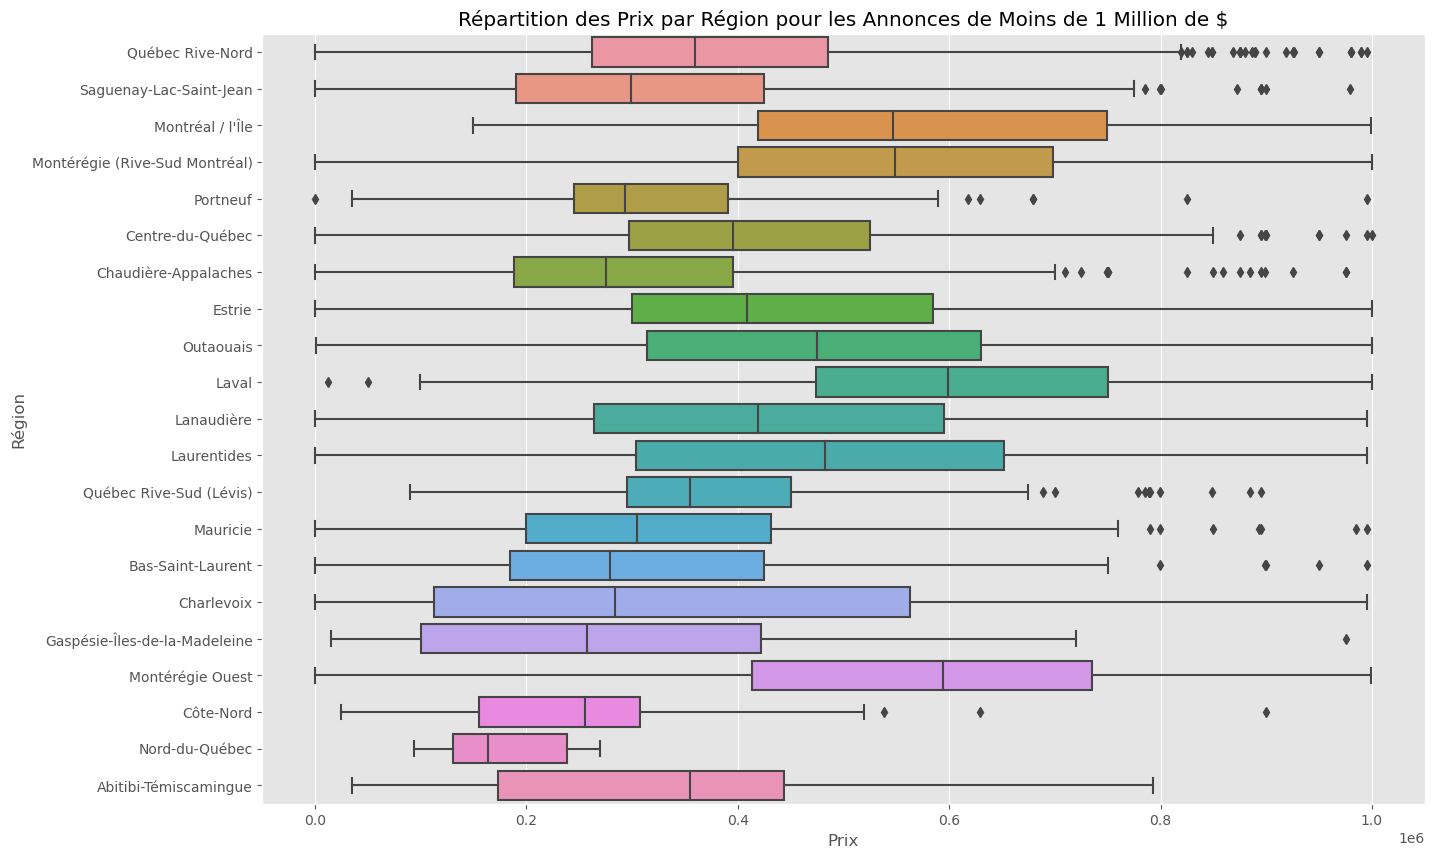

In [46]:
# Filtrer les données pour les annonces avec un prix inférieur à 1 million de dollars
data_under_1_million = house[house['prix'] < 1_000_000]

# Création d'un boxplot pour la répartition des prix par région
plt.figure(figsize=(15, 10))
sns.boxplot(x='prix', y='region', data=data_under_1_million)
plt.title("Répartition des Prix par Région pour les Annonces de Moins de 1 Million de $")
plt.xlabel("Prix")
plt.ylabel("Région")
plt.show()

#### 10. On s’intéresse pour cette question aux maisons de 2 chambres au moins et une salle de bain au moins et qui coûte moins de 1 million de $, pour toutes les régions. Dessiner dans un même graphique un boxplot représentant la répartition de prix par régions. Analyser de manière détaillée le graphique obtenu. Est-ce qu’il y a des différences entre ce graphique et celui de la question précédente ? Si oui donner en 4.

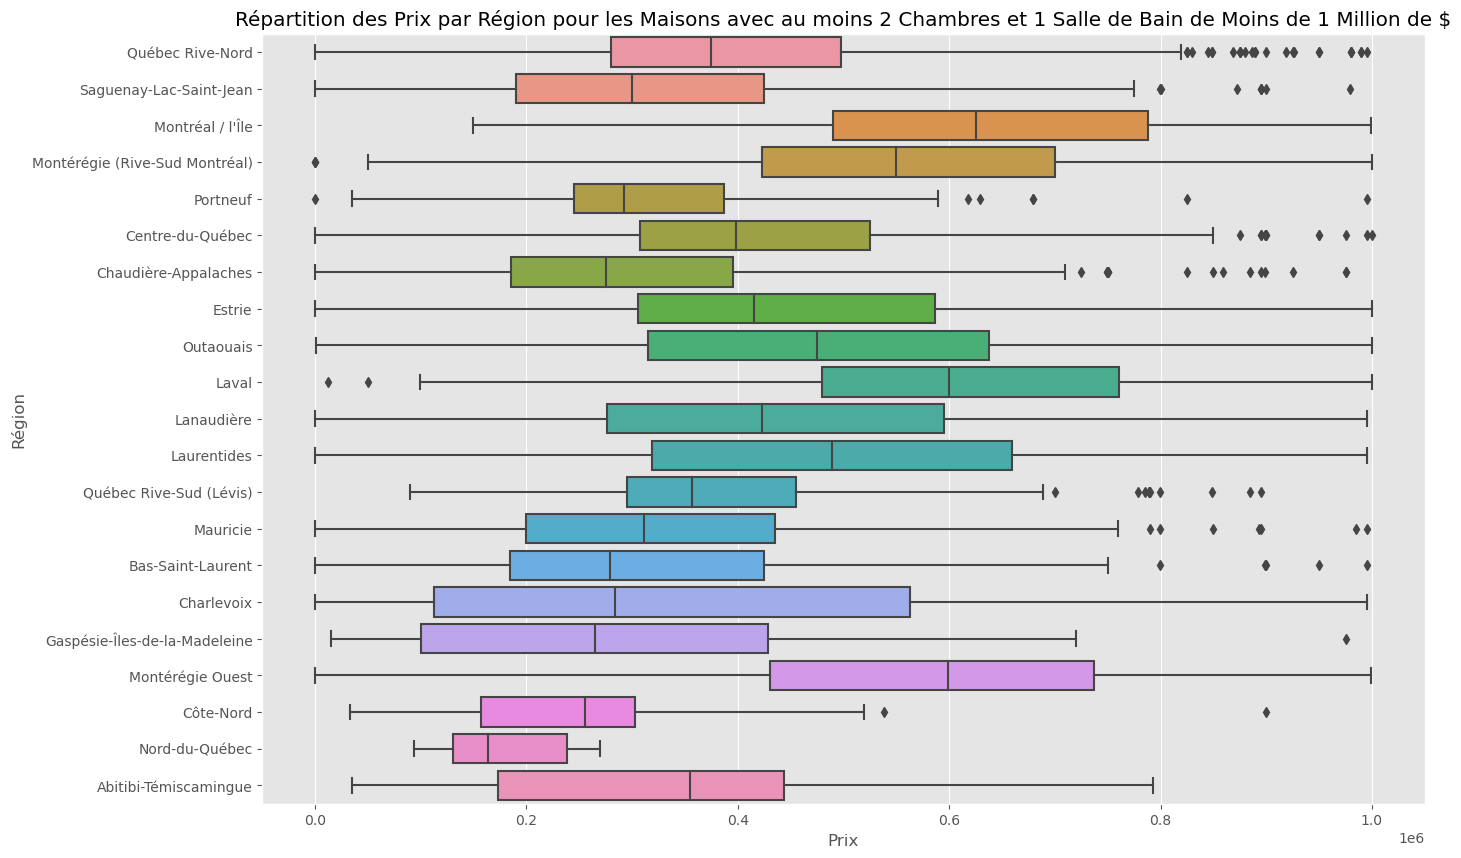

In [47]:
# Filtrer les données pour les maisons avec au moins 2 chambres, 1 salle de bain et un prix inférieur à 1 million de dollars
filtered_data_2_chambres = house[(house['chambres'] >= 2) & (house['salle_de_bain'] >= 1) & (house['prix'] < 1_000_000)]

# Création d'un boxplot pour la répartition des prix par région
plt.figure(figsize=(15, 10))
sns.boxplot(x='prix', y='region', data=filtered_data_2_chambres)
plt.title("Répartition des Prix par Région pour les Maisons avec au moins 2 Chambres et 1 Salle de Bain de Moins de 1 Million de $")
plt.xlabel("Prix")
plt.ylabel("Région")
plt.show()


#### 11. En un seul graphique, présenter une analyse bivariée de toutes les colonnes numériques de votre jeu de données. Analyser en détail le graphique obtenu.

In [48]:
#cette opération necessite un temps d'attente un peu long, c'est pourquoi je vais la commenter à après l'affichage du résultat.
#sns.pairplot(house)

# 4.4 Algorithmes de régression (6pts) :

#### 1. Dans la matrice de corrélation présentée ci-dessus, identifier 2 variables différentes qui ont le plus haut coefficient de corrélation. Concevez un modèle de régression linéaire dont l’une des valeurs est à prédire et l’autre est la valeur d’entrée. Le modèle de régression construit n’est autre qu’une droite. Vous devez représenter cette droite dans un graphique, ainsi que les points de données qui représentent les 2 variables. Est-ce que la droite telle que présentée sur votre graphique fait une bonne approximation de vos points/données? Vérifier votre réponse avec les données de test.

**Note**  les deux variables qui ont le meilleur coefficient de correlation sont: <br>
1. chambre <br>
2. Salle de bain

Avec un coefficient de 0.65 donc on va utiliser les deux variables.

* On va utiliser la variable **chambre** pour predire **Salle de bain**

In [49]:
x = house[['chambres']] # ici on a transformer les donnee en pandas dataframe pas une serie.
y = house['salle_de_bain']

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85, random_state=42)

In [52]:
x_train.shape, y_train.shape

((5797, 1), (5797,))

In [53]:
x_test.shape, y_test.shape

((1023, 1), (1023,))

In [54]:
# Entrainement du modele
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [55]:
# test
y_pred = lr.predict(x_test)

In [56]:
y_pred

array([1.56297091, 1.56297091, 1.56297091, ..., 1.56297091, 1.68457528,
       1.86453055])

In [57]:
y_test

239     1.000000
2850    1.000000
2687    1.000000
6198    3.000000
2684    1.688662
          ...   
6811    1.000000
5123    1.000000
3817    1.000000
5252    1.688662
6380    1.000000
Name: salle_de_bain, Length: 1023, dtype: float64

In [58]:
# Metrique d'evaluation du model

mean_squared_error(y_test, y_pred)

0.4638858182865418

<Axes: xlabel='salle_de_bain'>

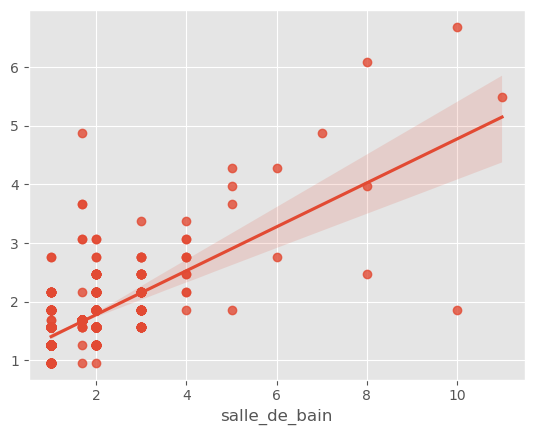

In [59]:
sns.regplot(x=y_test, y =y_pred)

In [60]:
house.head()

,prix,Taxes_municipales,Taxes_scolaires,Electricite,Assurances,ville,region,adresse,chambres,salle_de_bain,salle_d_eau,etage,Aire_habitable,Taille_du_terrain
0,549000.0,3270.880702,373.692328,1968.549376,1566.970707,Lac-Beauport,Québec Rive-Nord,"4, montée du Bois-Franc",4.0,2.0,1.131174,1.0,1050.00,14650.00
1,329000.0,3270.880702,373.692328,1968.549376,1566.970707,Jonquière (Arvida),Saguenay-Lac-Saint-Jean,"2263, rue Vallerand",5.0,2.0,1.131174,1.0,988.00,5.00
2,495000.0,2344.000000,232.000000,1500.000000,1566.970707,Anjou,Montréal / l'Île,"103-6850, boulevard des Roseraies",3.0,2.0,1.131174,1.0,1250.00,662.84
3,749000.0,4032.900000,427.490000,1968.549376,1566.970707,Longueuil (St-Hubert),Montérégie (Rive-Sud Montréal),"3450, rue Ovila-Hamel",7.0,2.0,1.000000,2.0,2.00,4.00
4,340000.0,1259.360000,130.820000,1000.000000,994.000000,St-Alban,Portneuf,"139, Chemins des Rapides",3.0,1.0,1.131174,1.0,1411.15,18023.09


In [61]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [62]:
le = LabelEncoder()

#### 2. Dans cette question, on s’intéresse à prédire si le prix d’une annonce sera supérieur ou inférieur à 350000$ en fonction de la région, du nombre de chambres, le nombre de salles de bain, le nombre de salles d’eau, le nombre d’étages, la superficie de l’aire habitable, la taille du terrain, les taxes municipales et les taxes scolaires. Concevez un modèle de régression qui permet de faire cette prédiction et évaluer votre modèle.

**Note** ici on va creer une variable suplementaire en qui sera de type boolean. Cette technique est appelle binning technique pour converture une variable numerique infini en une variable fini.

In [63]:
house['prix_binaire'] = house['prix'].apply(lambda x: 1 if x > 350000 else 0)
house['prix_binaire'].value_counts()

prix_binaire
1    4414
0    2406
Name: count, dtype: int64

In [64]:
# Sélection des colonnes pertinentes
features = ['region', 'chambres', 'salle_de_bain', 'salle_d_eau', 'etage', 'Aire_habitable', 'Taille_du_terrain', 'Taxes_municipales', 'Taxes_scolaires']
# target = 'prix_binaire'

# Impute les valeur manquantes

# Extraction des caractéristiques et de la cible
X = house[features]
y = house.prix_binaire

# Encodage des variables catégorielles (si nécessaire)
le = LabelEncoder()
X['region'] = le.fit_transform(X['region'])
# X_encoded = pd.get_dummies(X, columns=['region'], drop_first=True)


#Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)



In [65]:
#Entraînement du modèle de régression logistique
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

#Évaluation du modèle
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Mesures de performance
error = metrics.accuracy_score(y_test, y_pred)
# Affichage des résultats
print("L'error du modele Logistique regression est: ", error)

L'error du modele Logistique regression est:  0.6422287390029325


In [66]:
f1_score = metrics.f1_score(y_test, y_pred)
print("Le f1 score du regression logistique est:", f1_score)

Le f1 score du regression logistique est: 0.7816229116945107


In [67]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       368
           1       0.64      1.00      0.78       655

    accuracy                           0.64      1023
   macro avg       0.82      0.50      0.40      1023
weighted avg       0.77      0.64      0.50      1023



#### 3. Dans cette question, on s’intéresse à prédire le prix d’une annonce en fonction de la région, du nombre de chambres, le nombre de salles de bain, le nombre de salles d’eau, le nombre d’étages, la superficie de l’aire habitable, la taille du terrain, les taxes municipales et les taxes scolaires. Concevez un modèle de régression qui permet de faire cette prédiction et évaluer votre modèle

In [68]:

# Sélection des colonnes pertinentes
features = ['region', 'chambres', 'salle_de_bain', 'salle_d_eau', 'etage', 'Aire_habitable', 'Taille_du_terrain', 'Taxes_municipales', 'Taxes_scolaires']
target = 'prix'

# Extraction des caractéristiques et de la cible
X = house[features]
y = house[target]

# Encodage des variables catégorielles (si nécessaire)
le = LabelEncoder()
X['region'] = le.fit_transform(X['region'])
# X_encoded = pd.get_dummies(X, columns=['region'], drop_first=True)


#Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

#Entraînement du modèle de régression
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

#Évaluation du modèle
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Mesures de performance
error = metrics.mean_squared_error(y_test, y_pred)
# Affichage des résultats
print("L'error du modele de regression est: ", error)

L'error du modele de regression est:  163550885193.58316


#### 4. Le couple Formidable aimerait vendre 2 de ses propriétés. En vous servant de votre modèle construit ci-dessus, à combien est estimé le prix de vente de chacune des deux propriétés ? Voici les caractéristiques : <br>
* Propriété 1: région: Québec Rive-Nord, nombre de chambres: 3, nombre de salles de bain: 2, nombre de salles d’eau: 1, nombre d’étages: 2, superficie de l’aire habitable: 1700.2 pi2, taille du terrain: 5060 pi2, taxes municipales: 4272,39$, taxes scolaires: 411,06$, électricité: 3 584,00 $, assurances: 110,38$.
* Propriété 2: ville: Ferme-Neuve, région: Laurentides, taille du terrain 8021.06 pi2, taxes municipales: 2 324,75 $, taxes scolaires: 65,59$

In [69]:
le.classes_[9]

'Laurentides'

In [70]:
X.head(2)

,region,chambres,salle_de_bain,salle_d_eau,etage,Aire_habitable,Taille_du_terrain,Taxes_municipales,Taxes_scolaires
0,18,4.0,2.0,1.131174,1.0,1050.0,14650.0,3270.880702,373.692328
1,20,5.0,2.0,1.131174,1.0,988.0,5.0,3270.880702,373.692328


In [71]:
p1 = [[18, 3, 2, 1, 2,  1700.2, 5060, 4272.39 , 411.06
  ]]
prix_propriete_n01 = model.predict(p1)
print("La prediction du prix de la propriete No1 est: ", prix_propriete_n01)

La prediction du prix de la propriete No1 est:  [552827.88015303]


In [72]:
p2 = [[9, np.nan, np.nan, np.nan, np.nan,  np.nan, 8021.06, 2324.75 , 65.59
  ]]
prix_propriete_n01 = model.predict(p2)
print("La prediction du prix de la propriete No2 est: ", prix_propriete_n01)

La prediction du prix de la propriete No2 est:  [274580.77328022]


In [73]:
X

,region,chambres,salle_de_bain,salle_d_eau,etage,Aire_habitable,Taille_du_terrain,Taxes_municipales,Taxes_scolaires
0,18,4.000000,2.000000,1.131174,1.000000,1050.000000,1.465000e+04,3270.880702,373.692328
1,20,5.000000,2.000000,1.131174,1.000000,988.000000,5.000000e+00,3270.880702,373.692328
2,12,3.000000,2.000000,1.131174,1.000000,1250.000000,6.628400e+02,2344.000000,232.000000
3,13,7.000000,2.000000,1.000000,2.000000,2.000000,4.000000e+00,4032.900000,427.490000
4,17,3.000000,1.000000,1.131174,1.000000,1411.150000,1.802309e+04,1259.360000,130.820000
...,...,...,...,...,...,...,...,...,...
6815,13,3.000000,2.000000,1.000000,2.000000,1640.000000,4.276000e+03,3350.000000,750.000000
6816,18,3.000000,2.000000,1.000000,1.000000,1012.000000,3.184708e+07,2384.620000,493.700000
6817,7,8.000000,2.000000,1.131174,1.639486,1280.655809,3.184708e+07,3270.880702,373.692328
6818,7,3.403251,1.688662,1.131174,1.639486,1280.655809,3.184708e+07,1600.000000,373.692328


#### 5. Sans toutefois implémenter, pensez-vous que rajouter la ville dans vos 2 derniers modèles de régression concue améliorerait la prédiction ? Justifiez votre réponse (un graphique ou un calcul).

In [74]:
house_2 = house.copy()

In [75]:
house_2['region'] = le.fit_transform(house_2['region'])
house_2['ville'] = le.fit_transform(house_2['ville'])
house_2['adresse'] = le.fit_transform(house_2['adresse'])

In [76]:
house_2.corr()['ville']

prix                 0.015630
Taxes_municipales   -0.000938
Taxes_scolaires     -0.016393
Electricite          0.003110
Assurances           0.001331
ville                1.000000
region              -0.110162
adresse             -0.012065
chambres             0.020089
salle_de_bain        0.002557
salle_d_eau          0.013596
etage                0.017059
Aire_habitable       0.024238
Taille_du_terrain   -0.010063
prix_binaire        -0.050076
Name: ville, dtype: float64

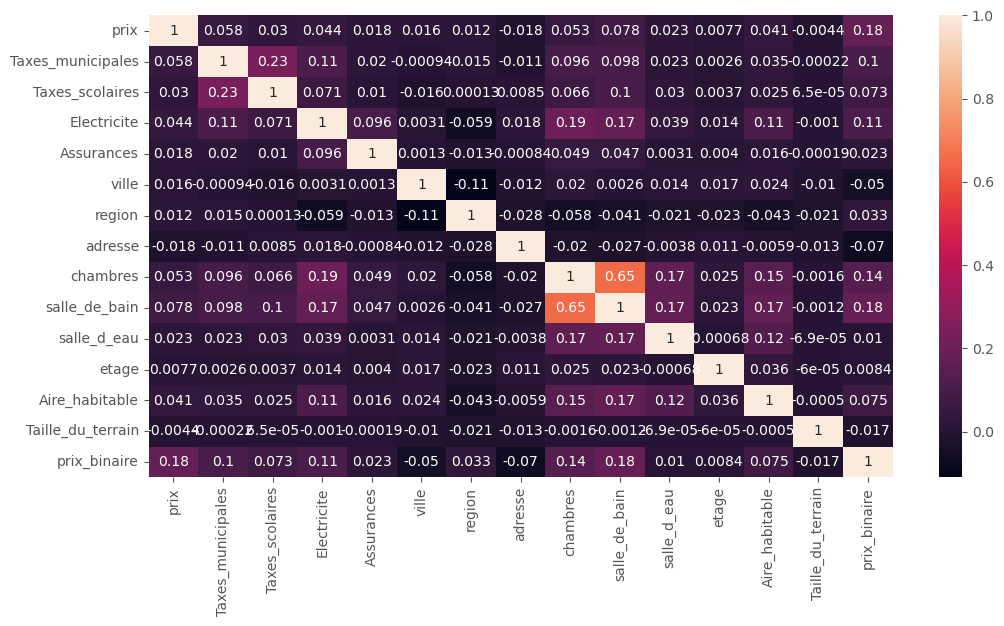

In [77]:
plt.figure(figsize=(12,6))
sns.heatmap(house_2.corr(), annot=True)
plt.show()